# Classifying pictures of Dogs vs Cats. 

We'll begin these exercises with the most basic type of neural network and move into the more modern and complicated kinds. This will also work nicely to move through some of the features of Keras. 

To get started we will load the necessary packages and write some functions to load the data into suitable forms for doing computation on them. This will load the images into numpy arrays that are in the shape (num_pics, channels, width, height).

In [72]:
import os
import numpy as np
from skimage.io import imread, imshow
from skimage import transform

# path to the saved folder from Kaggle and the number of pixels to use for height and width
PATH = 'data/demo'
PIXELS = 64

def load_images(path):
    # read all of the image files in the directory
    names = [d for d in os.listdir(path) if d.endswith('.jpg')]
    
    print 'Making dataset'
    # set up an empty numpy array for our images
    training_images = np.zeros((len(names), 3, PIXELS, PIXELS), dtype=np.float32)
    labels = []
    for i, n in enumerate(names):
        #print n
        img = imread(os.path.join(path, n))
        # skimage loads image as (height, width, channel) for RGB images channels = 3
        img = transform.resize(img, output_shape=(PIXELS, PIXELS , 3), preserve_range=True)
        training_images[i,:,:,:] = img.transpose(2,0,1)
        
        # check the label on the filename and encode the label into integers
        if n.split('.')[0] == 'cat':
            labels.append(0) # I'm sort of a dog person so dogs will be 1
        else:
            labels.append(1)
            
    return training_images, np.asarray(labels)

X_train, y_train = load_images(PATH)
print X_train.shape
print y_train.shape
print 'Done!'

Making dataset
(2000, 3, 64, 64)
(2000,)
Done!


Once we have the data in a suitable form we can check the images to make sure that they look ok. Also to make sure that we didn't mess up the indexing for the labels somehow. 

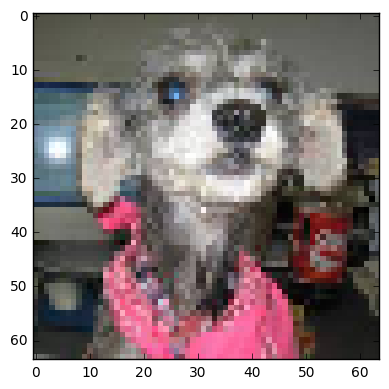

1


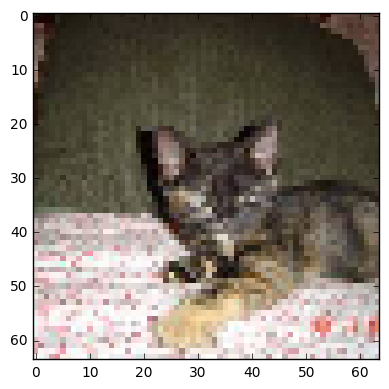

0


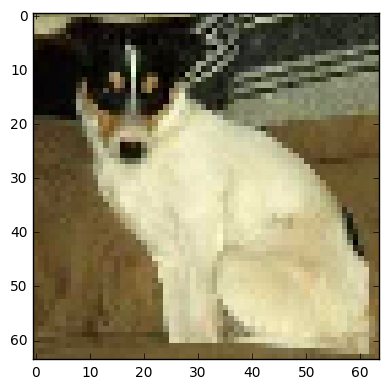

1


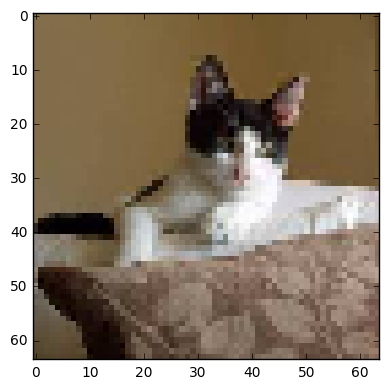

0


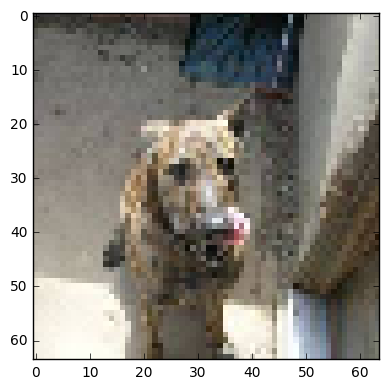

1


In [73]:
from random import randint
%matplotlib inline
from matplotlib import pyplot

def plot_sample(img):
    # we have to tranpose the image back to it's original shape
    # also for some reason imshow in skimage wants images to be float between 0-1 so we divide by it's max
    imshow(img.transpose(1,2,0) / np.amax(img))
    pyplot.show(block=True)

# We'll pick 5 random images, plot them and print their labels
for _ in range(0,5):
    j = randint(0, X_train.shape[0])
    plot_sample(X_train[j])
    print y_train[j]

Now we have our data in a suitable form we can start to train some models on it. 

Since we are going to go in order from simple neural network to modern neural network we will start with a simple linear model. To get a baseline we'll implement it in sklearn. Then do the same exact thing with Keras. 

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle


# have to reshape the images to flat, logistic regression can't handle tensors like ConvNets can
# save this value for that later
num_features = 3*PIXELS*PIXELS

# I'm lazy, which why I like deep learning. So I'll use sklearn to shuffle and split the data
X_train, y_train = shuffle(X_train, y_train)

# should give us 40 training images and 10 testing images to eval performance on
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

logit = LogisticRegression()

logit.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = logit.predict_proba(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds[:,1])

0.48727844123192959

Ok so that wasn't really interesting because it's a logistic regression from sklearn. But, it's essentially the same as the most basic type of neural network. So we'll implement the that type of neural network with a neural network library. The result should be the same.

In [75]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam

logit_input = Input(shape=(num_features,), name='Input', dtype='float32')
probs = Dense(1, activation='sigmoid')(logit_input)
model = Model(input=logit_input, output=probs)

adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = model.predict(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds)

Epoch 1/10
1600/1600 [==============================] - 0s - loss: 7.8318 - acc: 0.5088     
Epoch 2/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 3/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 4/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 5/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 6/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 7/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 8/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 9/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 10/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     


0.5

OK so that was pretty terrible. But logistic regression is not the right tool for an image recognition task. So lets actually implement some neural networks.

We'll first take the same response that the community had when it was pointed out that a perceptron couldn't solve XOR. The following code will produce a multilayer perceptron. 

In [76]:
mlp_input = Input(shape=(num_features,), name='Input', dtype='float32')

fc1 = Dense(32, activation='relu')(mlp_input)
fc2 = Dense(32, activation='relu')(fc1)
probs = Dense(1, activation='sigmoid')(fc2)

model = Model(input=mlp_input, output=probs)
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = model.predict(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds)

Epoch 1/10
1600/1600 [==============================] - 0s - loss: 8.2256 - acc: 0.4888     
Epoch 2/10
1600/1600 [==============================] - 0s - loss: 8.2102 - acc: 0.4906     
Epoch 3/10
1600/1600 [==============================] - 0s - loss: 8.2102 - acc: 0.4906     
Epoch 4/10
1600/1600 [==============================] - 0s - loss: 8.2102 - acc: 0.4906     
Epoch 5/10
1600/1600 [==============================] - 0s - loss: 8.2102 - acc: 0.4906     
Epoch 6/10
1600/1600 [==============================] - 0s - loss: 8.2102 - acc: 0.4906     
Epoch 7/10
1600/1600 [==============================] - 0s - loss: 8.2102 - acc: 0.4906     
Epoch 8/10
1600/1600 [==============================] - 0s - loss: 8.2102 - acc: 0.4906     
Epoch 9/10
1600/1600 [==============================] - 0s - loss: 8.2102 - acc: 0.4906     
Epoch 10/10
1600/1600 [==============================] - 0s - loss: 8.2102 - acc: 0.4906     


0.5

### Convolutional Neural Networks

So now we'll get to the architectures that kick started the deep learning hype in 2012. Convolutional neural networks. This is a pretty tiny one compared to todays standards, but it should also run fine on a CPU. So it will be easy to play with on a laptop.

In [77]:
from keras.layers import Convolution2D, MaxPooling2D, Flatten

cnn_input = Input(shape=(3, PIXELS, PIXELS), name='Input', dtype='float32')

conv_1 = Convolution2D(8, 3,3, activation='relu')(cnn_input)
pool_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Convolution2D(16, 3,3, activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

flat = Flatten()(pool_2)

fc1 = Dense(32, activation='relu')(flat)
fc2 = Dense(32, activation='relu')(fc1)

probs = Dense(1, activation='sigmoid')(fc2)

model = Model(input=cnn_input, output=probs)
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train, y_train)

preds = model.predict(X_test)

roc_auc_score(y_test, preds)

Epoch 1/10
1600/1600 [==============================] - 0s - loss: 3.0913 - acc: 0.5394     
Epoch 2/10
1600/1600 [==============================] - 0s - loss: 0.7723 - acc: 0.5956     
Epoch 3/10
1600/1600 [==============================] - 0s - loss: 0.6117 - acc: 0.6637     
Epoch 4/10
1600/1600 [==============================] - 0s - loss: 0.5144 - acc: 0.7262     
Epoch 5/10
1600/1600 [==============================] - 0s - loss: 0.4495 - acc: 0.7869     
Epoch 6/10
1600/1600 [==============================] - 0s - loss: 0.3765 - acc: 0.8281     
Epoch 7/10
1600/1600 [==============================] - 0s - loss: 0.2859 - acc: 0.8819     
Epoch 8/10
1600/1600 [==============================] - 0s - loss: 0.2287 - acc: 0.9094     
Epoch 9/10
1600/1600 [==============================] - 0s - loss: 0.1713 - acc: 0.9363     
Epoch 10/10
1600/1600 [==============================] - 0s - loss: 0.1169 - acc: 0.9681     


0.65692017598994346

The performance was improved but with such a small dataset we can't train a larger more powerful network. If we try something more similar to a modern net we'll overfit like crazy and our test set performance will be terrible. 

In [78]:
cnn_input = Input(shape=(3, PIXELS, PIXELS), name='Input', dtype='float32')

conv_1 = Convolution2D(32, 3,3, activation='relu')(cnn_input)
pool_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Convolution2D(64, 3,3, activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

flat = Flatten()(pool_2)

fc1 = Dense(32, activation='relu')(flat)
fc2 = Dense(32, activation='relu')(fc1)

probs = Dense(1, activation='sigmoid')(fc2)

model = Model(input=cnn_input, output=probs)
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train, y_train)

preds = model.predict(X_test)

roc_auc_score(y_test, preds)

Epoch 1/10
1600/1600 [==============================] - 0s - loss: 7.8067 - acc: 0.5069     
Epoch 2/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 3/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 4/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 5/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 6/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 7/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 8/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 9/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     
Epoch 10/10
1600/1600 [==============================] - 0s - loss: 7.8217 - acc: 0.5094     


0.5

For most practical applications we won't have access to the amount of data necessary to train a really powerful network. Instead we'll use one that's already been trained on millions of natural images across 1000 classes and finetune it to our needs. 

In [79]:
import h5py
from keras.models import Sequential
from keras.layers import Dropout, ZeroPadding2D
from keras.utils.layer_utils import print_summary

# source: https://gist.github.com/zo7/41ce4cccfcfe8f0bff1b4ad82d0ee451
VGG_PATH = 'vgg16_weights.h5'

# only create and load weights to the convolutional part of the VGG16 network
vgg_model = Sequential()
vgg_model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
vgg_model.add(Convolution2D(64, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(64, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(128, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(128, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

f = h5py.File(VGG_PATH)
for layer in range(f.attrs['nb_layers']):
    # only go as far as deep as our current model
    if layer >= len(vgg_model.layers):
        break
    g = f['layer_{}'.format(layer)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    vgg_model.layers[layer].set_weights(weights)
f.close()

print_summary(vgg_model.layers)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_40 (ZeroPadding2D) (None, 3, 226, 226)   0           zeropadding2d_input_4[0][0]      
____________________________________________________________________________________________________
convolution2d_104 (Convolution2D)(None, 64, 224, 224)  1792        zeropadding2d_40[0][0]           
____________________________________________________________________________________________________
zeropadding2d_41 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_104[0][0]          
____________________________________________________________________________________________________
convolution2d_105 (Convolution2D)(None, 64, 224, 224)  36928       zeropadding2d_41[0][0]           
___________________________________________________________________________________________

One thing that's important when using a pretrained model is that the input data has to be the exact same format and preprocessed in the same way that the data was for the original model. 

So we have to load the dataset back in a much bigger size. And also do a per channel mean subtraction. The important thing to keep in mind is that the mean from each channel is cominig from the ImageNet dataset not our dataset. 

In [80]:
# path to the saved folder from Kaggle and the number of pixels to use for height and width
PATH = 'data/demo'
PIXELS = 224

def load_images(path):
    # read all of the image files in the directory
    names = [d for d in os.listdir(path) if d.endswith('.jpg')]
    
    print 'Making dataset'
    # set up an empty numpy array for our images
    training_images = np.zeros((len(names), 3, PIXELS, PIXELS), dtype=np.float32)
    labels = []
    for i, n in enumerate(names):
        #print n
        img = imread(os.path.join(path, n))
        # skimage loads image as (height, width, channel) for RGB images channels = 3
        img = transform.resize(img, output_shape=(PIXELS, PIXELS , 3), preserve_range=True)
        training_images[i,:,:,:] = img.transpose(2,0,1)
        
        # check the label on the filename and encode the label into integers
        if n.split('.')[0] == 'cat':
            labels.append(0) # I'm sort of a dog person so dogs will be 1
        else:
            labels.append(1)
            
    return training_images, np.asarray(labels)

X_train, y_train = load_images(PATH)
X_train = X_train[:,[2,1,0],:,:] # swap from RGB to BGR
X_train[:,0,:,:] -= 103.939
X_train[:,1,:,:] -= 116.779
X_train[:,2,:,:] -= 123.68

Making dataset


In [81]:

#def plot_sample(img):
    # we have to tranpose the image back to it's original shape
    # also for some reason imshow in skimage wants images to be float between 0-1 so we divide by it's max
#    imshow(img.transpose(1,2,0) / abs(max(np.amax(img), np.amin(img))))
#    pyplot.show(block=True)

# We'll pick 5 random images, plot them and print their labels
#for _ in range(0,5):
#    j = randint(0, X_train.shape[0])
#    plot_sample(X_train[j])
#    print y_train[j]

The images look pretty trippy this time because we centered each channel around 0 and imshow from skimage doesn't expect negative values. Honestly, the images are better that way. 

In [82]:
# set up training and testing sets again
X_train, y_train = shuffle(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

# Add our own classifier layers on the bottom
vgg_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation='sigmoid'))

# optional set the convolutional layers so they won't be trained.
for layer in vgg_model.layers[:25]:
    layer.trainable = False

adam = Adam(lr=0.0001)
vgg_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

vgg_model.fit(X_train,y_train, nb_epoch=5)

preds = vgg_model.predict(X_test)

roc_auc_score(y_test, preds)

Epoch 1/5
1600/1600 [==============================] - 10s - loss: 0.9598 - acc: 0.8894    
Epoch 2/5
1600/1600 [==============================] - 10s - loss: 0.1195 - acc: 0.9712    
Epoch 3/5
1600/1600 [==============================] - 10s - loss: 0.0635 - acc: 0.9856    
Epoch 4/5
1600/1600 [==============================] - 10s - loss: 0.0311 - acc: 0.9925    
Epoch 5/5
1600/1600 [==============================] - 10s - loss: 0.0061 - acc: 0.9975    


0.99632463246324632

Now we pretty much nailed it. 

## Training loops and tricks. 

When humans are classifying images we tend to be pretty invariant to random changes in the images. Meaning that we can still a dog from a cat if the images are rotated, have different lighting, are skewed in some way, or partially blocked or something like that. 

We can attempt to get a neural network to be invariant to these changes as well by randomly perturbing the input to the network. The two strategies that you can use is to generate new data with random changes and append it to the original data or we can make small adjustments to each image as we are feeding it to the network. I tend to favor the second option because it requires less space on disk or in memory and it results in more random shifts than would be possible if you were to generate them ahead of time. If you have a dataset of millions of images and you are going to loop over them 100 times, generate 100 randomly changed copies of each image would be crazy. If you generate them on the fly then you are not limited to the memory of the computer. 

![Imgur](http://i.imgur.com/rW0a8Yx.png)![Imgur](http://i.imgur.com/Xg6zouG.gif)

This has become pretty standard practice when training ConvNets for image classification and I can't think of any reason not to use at least a very basic version of this. At the minimum I would recommend always using random translations and if your dataset is appropriate horizontal flipping. With translations you are helping your network learn to find useful patterns of features no matter where they appear in the image. With horizontal flipping you are able to make drastic changes to the input images at the pixel level while still keeping all of the distinguishing qualities of the image classes intact. 

### Data augmentation in Keras

When doing these types of augmentations with Keras it's very simple because we can just use some built in functionality of the library. 

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Using this datagenerater is also pretty simple. We just have to fit the datagen to our dataset so that it gets an idea about the sizes of the images and how many there are. Then we use the .flow() and fit_generator() functions from the datagenerator and model. 

In [84]:

# fit the datagen on our X_train data
datagen.fit(X_train)

# fit the model using data augmentations
vgg_model.fit_generator(datagen.flow(X_train, y_train), samples_per_epoch=len(X_train), nb_epoch=5)

# see if we did any better
preds = vgg_model.predict(X_test)

roc_auc_score(y_test, preds)

Epoch 1/5
1600/1600 [==============================] - 10s - loss: 0.2058 - acc: 0.9469    
Epoch 2/5
1600/1600 [==============================] - 10s - loss: 0.1839 - acc: 0.9300    
Epoch 3/5
1600/1600 [==============================] - 10s - loss: 0.1527 - acc: 0.9350    
Epoch 4/5
1600/1600 [==============================] - 10s - loss: 0.0771 - acc: 0.9688    
Epoch 5/5
1600/1600 [==============================] - 10s - loss: 0.0748 - acc: 0.9750    


0.99904990499049906

So we cheated a little because we loaded the same big VGG model that we already trained on the dataset. But what's interesting is that the loss went up and the accuracy went down compared to the first time that we trained the model. This is because with the augmentations the training dataset actually got a lot harder because the network won't see the exact same two images ever. But, this really paid off for the test set, the ROC score went up even though it looked like the training performance got worse. 

#### Making your own iterator

The Keras iterator is great and allows you to get things rolling pretty quickly. But, you are limited to whatever they have built in. Sometimes you need to do something specific to your data before it hits the network that isn't built in. So it's simple to just make a generator or iterator in python to spit out the processed batches of data. In that case the model in keras has a couple of other functions that you'll be using instead of .fit() or .predict(). So if you are generating batches of data then you will use model.train_on_batch() to train your network and then model.evaluate() for testing your network on batches of test data.

```python
for epoch in range(ITERS):
    start = time.time()
    #loss = batch_iterator(x_train, y_train, 64, model)
    batch_loss = []
    batch_acc = []
    for X_batch, y_batch in batch_iter(X_train, y_train):
        loss, acc_t = model.train_on_batch(X_batch, y_batch)
        batch_loss.append(loss)
        batch_acc.append(acc_t)

    train_loss.append(np.mean(batch_loss))
    train_acc.append(np.mean(batch_acc))
    #train_loss.append(loss)
    v_loss, v_acc = model.evaluate(X_test, y_test, batch_size=BATCHSIZE, verbose = 0)
    valid_loss.append(v_loss)
    valid_acc.append(v_acc)
```